<a href="https://colab.research.google.com/github/suibhne-ofoighil/cmplxsys530-labs/blob/main/PredatorPreyModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyCX Predator Prey Model

Adapted from Hiroki Sayama's PyCX module. For more information about the model, please see Sections 4.6 and 19.4 of Sayama’s book (Introduction to the Modeling and Analysis of Complex Systems).

In [2]:
!pip install -q pyDOE

In [3]:
from pyDOE import lhs
from statistics import median
import copy as cp
import numpy.matlib as npm
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
from IPython import display
import time

%matplotlib inline

### Set up model parameters

In [4]:
nr = 500. # carrying capacity of rabbits ***

r_init = 100 # initial rabbit population
mr = 0.03 # magnitude of movement of rabbits
dr = 1.0 # death rate of rabbits when it faces foxes ***
rr = 0.1 # reproduction rate of rabbits

f_init = 30 # initial fox population
mf = 0.05 # magnitude of movement of foxes
df = 0.1 # death rate of foxes when there is no food ***
rf = 0.5 # reproduction rate of foxes ***

cd = 0.02 # radius for collision detection
cdsq = cd ** 2

### Model functions

In [5]:
class agent:
    pass

def initialize():
    global agents, rdata, fdata, Nrabbits, Nfoxes
    agents = []
    rdata = []
    fdata = []
    for i in range(r_init + f_init):
        ag = agent()
        ag.type = 'r' if i < r_init else 'f'
        ag.x = random.random()
        ag.y = random.random()
        agents.append(ag)

    Nrabbits = sum([1 for x in agents if x.type == 'r'])
    Nfoxes = sum([1 for x in agents if x.type == 'f'])

def observe():
    global agents, rdata, fdata

    plt.subplot(2, 1, 1)
    plt.cla()
    rabbits = [ag for ag in agents if ag.type == 'r']
    if len(rabbits) > 0:
        x = [ag.x for ag in rabbits]
        y = [ag.y for ag in rabbits]
        plt.plot(x, y, 'b.')
    foxes = [ag for ag in agents if ag.type == 'f']
    if len(foxes) > 0:
        x = [ag.x for ag in foxes]
        y = [ag.y for ag in foxes]
        plt.plot(x, y, 'ro')
    plt.axis('image')
    plt.axis([0, 1, 0, 1])

    plt.subplot(2, 1, 2)
    plt.cla()
    plt.plot(rdata, label = 'prey')
    plt.plot(fdata, label = 'predator')
    plt.legend()

def update():
    global agents, rdata, fdata, Nrabbits, Nfoxes
    t = 0.

    while t < 1. and len(agents) > 0:
        t += 1. / len(agents)
        update_one_agent()
    
    Nrabbits = sum([1 for x in agents if x.type == 'r'])
    Nfoxes = sum([1 for x in agents if x.type == 'f'])
    rdata.append(Nrabbits)
    fdata.append(Nfoxes)

def update_one_agent():
    global agents, rdata, fdata, Nrabbits, Nfoxes
    if agents == []:
        return

    if Nrabbits == 0:
      rdata.append(0)
      fdata.append(0)
      return

    if Nfoxes == 0 and Nrabbits != 0:
      rdata.append(nr)
      fdata.append(0)
      return

    ag = random.choice(agents)

    # simulating random movement
    m = mr if ag.type == 'r' else mf
    ag.x += random.uniform(-m, m)
    ag.y += random.uniform(-m, m)
    ag.x = 1 if ag.x > 1 else 0 if ag.x < 0 else ag.x
    ag.y = 1 if ag.y > 1 else 0 if ag.y < 0 else ag.y

    # detecting collision and simulating death or birth
    neighbors = [nb for nb in agents if nb.type != ag.type
                 and (ag.x - nb.x)**2 + (ag.y - nb.y)**2 < cdsq]

    if ag.type == 'r':
        if len(neighbors) > 0: # if there are foxes nearby
            if random.random() < dr:
                agents.remove(ag)
                return
        if random.random() < rr*(1-sum([1 for x in agents if x.type == 'r'])/nr):
            agents.append(cp.copy(ag))
    else:
        if len(neighbors) == 0: # if there are no rabbits nearby
            if random.random() < df:
                agents.remove(ag)
                return
        else: # if there are rabbits nearby
            if random.random() < rf:
                agents.append(cp.copy(ag))

### Examples of running the model

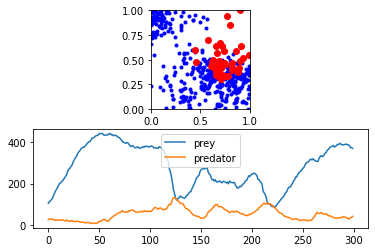

In [8]:
# Test out our model functions to make sure they work
initialize()
for i in range(300):
  update()
observe()

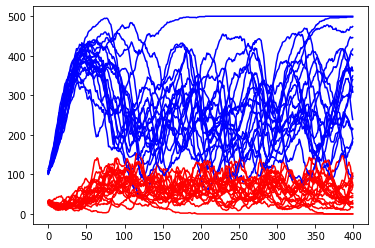

In [ ]:
# Run the model live inline for a specified number of steps
for i in range(20):
  initialize()
  [ update() for i in range(400) ]
  plt.plot(range(400), rdata, color='b')
  plt.plot(range(400), fdata, color='r')

In [ ]:
nrs = [200, 300, 400, 500, 600, 700, 800] #carry capacities
sim_len = 400
sims_per_nr = 10
rData = []
fData = []

for nr_i in nrs:
  nr = nr_i
  rData_nr = np.zeros(shape=(sims_per_nr, sim_len))
  fData_nr = np.zeros(shape=(sims_per_nr, sim_len))
  for s in range(sims_per_nr):
    initialize()
    [ update() for i in range(sim_len) ]
    rData_nr[s] = rdata
    fData_nr[s] = fdata
  rData.append(rData_nr)
  fData.append(fData_nr)
  print(f'Finished {nr_i}')

Finished 200
Finished 300
Finished 400
Finished 500
Finished 600
Finished 700
Finished 800


Text(0.5, 1.0, 'Mean Ending Populations as Function of Carrying Capacities')

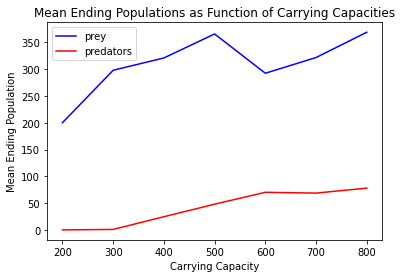

In [ ]:
rMeanEndingPops = []
fMeanEndingPops = []
for rMat, fMat in zip(rData, fData):
  rMeanEndingPops.append(rMat[:, sim_len - 1].mean()) # last timestep population measure
  fMeanEndingPops.append(fMat[:, sim_len - 1].mean())

plt.plot(nrs, rMeanEndingPops, color='b')
plt.plot(nrs, fMeanEndingPops, color='r')
plt.legend(['prey', 'predators'])
plt.xlabel('Carrying Capacity')
plt.ylabel('Mean Ending Population')
plt.title('Mean Ending Populations as Function of Carrying Capacities')

Text(0.5, 1.0, 'Quartile Ending Populations as Function of Carrying Capacities \n Quartiles = (0.05, 0.25, 0.5, 0.75, 0.95)')

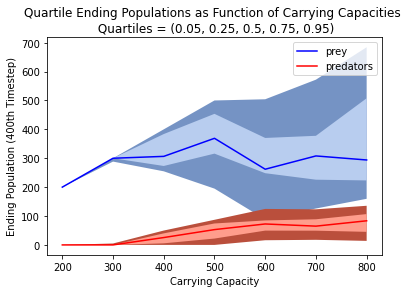

In [ ]:

quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
rQuantileMat = np.zeros(shape=(len(quantiles), len(nrs)))
fQuantileMat = np.zeros(shape=(len(quantiles), len(nrs)))


for i, mats in enumerate(zip(rData, fData)):
  rMat, fMat = mats
  rStats = []
  fStats = []

  for q in quantiles:
    rStats.append(np.quantile(rMat[:, sim_len - 1], q)) #get quantile from sims
    fStats.append(np.quantile(fMat[:, sim_len - 1], q))

  rQuantileMat[:, i] = rStats
  fQuantileMat[:, i] = fStats

plt.fill_between(nrs, rQuantileMat[0], rQuantileMat[4], facecolor='#7593C4')
plt.fill_between(nrs, rQuantileMat[1], rQuantileMat[3], facecolor='#B8CDEF')
plt.plot(nrs, rQuantileMat[2], color='b')

plt.fill_between(nrs, fQuantileMat[0], fQuantileMat[4], facecolor='#ba4f3c')
plt.fill_between(nrs, fQuantileMat[1], fQuantileMat[3], facecolor='#ff9d8c')
plt.plot(nrs, fQuantileMat[2], color='r')

plt.legend(['prey', 'predators'])
plt.xlabel('Carrying Capacity')
plt.ylabel('Ending Population (400th Timestep)')
plt.title('Quartile Ending Populations as Function of Carrying Capacities \n Quartiles = (0.05, 0.25, 0.5, 0.75, 0.95)')

# Latin Hypercube Sampling
Parameters:
*   nr = the carrying capacity for rabbits
*   dr = the death probability for rabbits when they encounter a fox
*   df = the death probability for foxes when they have no food
*   rf = the reproduction probability for foxes if there is food (rabbits) nearby

In [6]:
nsamples = 100
reruns = 2
nparams = 4
Timesteps = 400

# Set up parameter array
params = npm.repmat(lhs(nparams, samples = nsamples),reruns,1) 
# Each row is a new parameter set
# rMat = np.zeros(shape=(nsamples*reruns, Timesteps))
# fMat = np.zeros(shape=(nsamples*reruns, Timesteps))
rEndingPops = []
fEndingPops = []

# Run the simulations!
for i in range(0,nsamples*reruns):
    nr = params[i,0]*(700-200) + 200 # carrying capacity for rabbits
                                     # note we have rescaled the 0,1 range of params[i,0] to match the range for nr!
    dr = params[i,1]*0.5+0.5 # death probability for rabbits when encountering fox
    df = params[i,2]*0.25  # death probability for foxes when no food available
    rf = params[i,3]*0.5+0.25 # reproduction probability for foxes when food available
    
    initialize()
    [ update() for t in range(400) ]
    rEndingPops.append(rdata[-1])
    fEndingPops.append(fdata[-1])

    print(i, end=' ')
    if i % 20 == 0 and i == 0: print('\n')

0 

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

Text(0.5, 1.0, 'Ending Populations (400 Timesteps) after 200 Simulations')

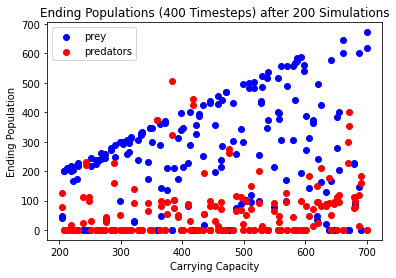

In [10]:
nrs = params[:, 0]*(700-200) + 200
plt.scatter(x=nrs, y=rEndingPops, color='b')
plt.scatter(x=nrs, y=fEndingPops, color='r')
plt.legend(['prey', 'predators'])
plt.ylabel('Ending Population')
plt.xlabel('Carrying Capacity')
plt.title('Ending Populations (400 Timesteps) after 200 Simulations')

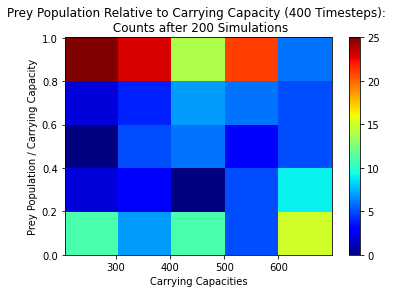

In [11]:
carryingCapacities = np.array([ params[i,0]*(700-200) + 200 for i in range(nsamples*reruns) ])
rPopsRelativeToCarryingCaps = np.array(rEndingPops) / carryingCapacities
plt.hist2d(carryingCapacities, rPopsRelativeToCarryingCaps, bins=(5,5), cmap='jet')
plt.title('Prey Population Relative to Carrying Capacity (400 Timesteps): \n Counts after 200 Simulations')
plt.xlabel('Carrying Capacities')
plt.ylabel('Prey Population / Carrying Capacity')
plt.colorbar()

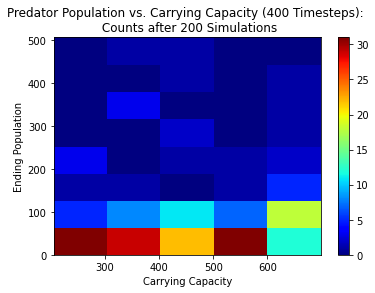

In [12]:
plt.hist2d(carryingCapacities, fEndingPops, bins=(5,8), cmap='jet')
plt.title('Predator Population vs. Carrying Capacity (400 Timesteps): \n Counts after 200 Simulations')
plt.xlabel('Carrying Capacity')
plt.ylabel('Ending Population')
plt.colorbar()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


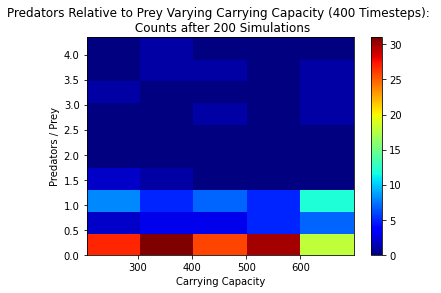

In [13]:
fOverRpops = np.array(fEndingPops) / np.array(rEndingPops)
np.nan_to_num(fOverRpops, copy=False, posinf=True)
filteredRatios = fOverRpops[fOverRpops < 10]
filteredCapacities = carryingCapacities[fOverRpops < 10]
plt.hist2d(filteredCapacities, filteredRatios, bins=(5,10), cmap='jet')
plt.title('Predators Relative to Prey Varying Carrying Capacity (400 Timesteps): \n Counts after 200 Simulations')
plt.xlabel('Carrying Capacity')
plt.ylabel('Predators / Prey')
plt.colorbar()

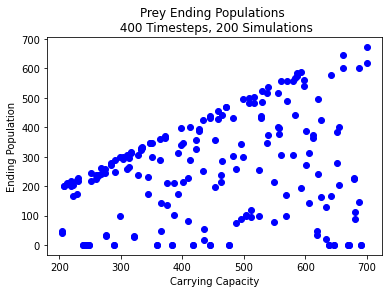

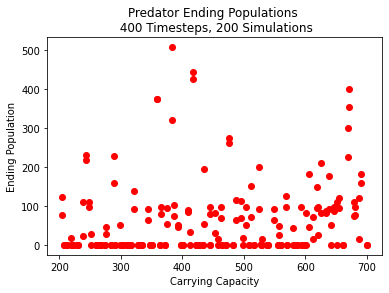

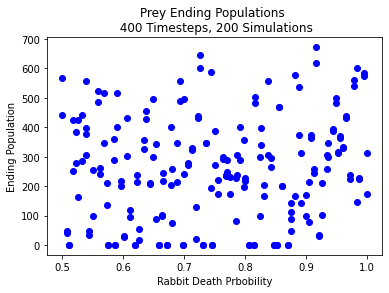

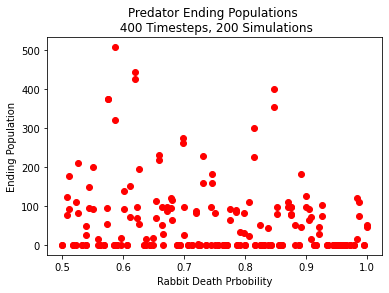

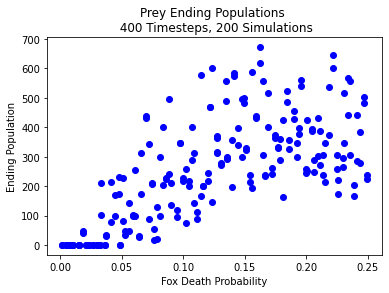

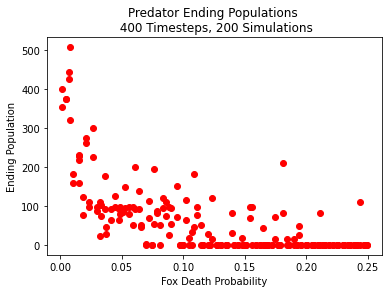

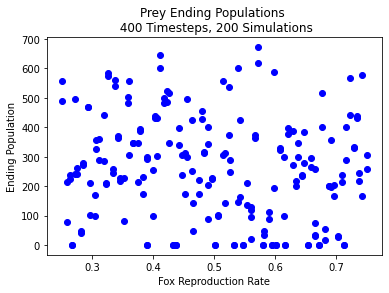

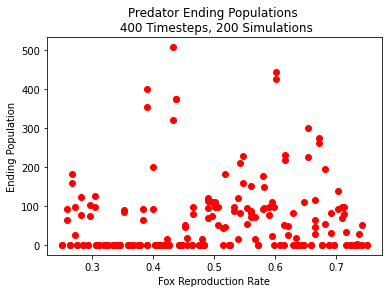

In [15]:
paramLabels = ['Carrying Capacity', 'Rabbit Death Prbobility', 'Fox Death Probability', 'Fox Reproduction Rate']

parms  = [
          params[:,0]*(700-200) + 200, # carrying capacity for rabbits
          params[:,1]*0.5+0.5, # death probability for rabbits when encountering fox
          params[:,2]*0.25, # death probability for foxes when no food available
          params[:,3]*0.5+0.25 # reproduction probability for foxes when food available
]                  

for i, pkg in enumerate(zip(paramLabels, parms)):
  label, paramInstances = pkg

  plt.scatter(x=paramInstances, y=rEndingPops, color='b')
  plt.ylabel('Ending Population')
  plt.xlabel(label)
  plt.title('Prey Ending Populations \n 400 Timesteps, 200 Simulations')
  plt.show()

  plt.scatter(x=paramInstances, y=fEndingPops, color='r')
  plt.ylabel('Ending Population')
  plt.xlabel(label)
  plt.title('Predator Ending Populations \n 400 Timesteps, 200 Simulations')
  plt.show()


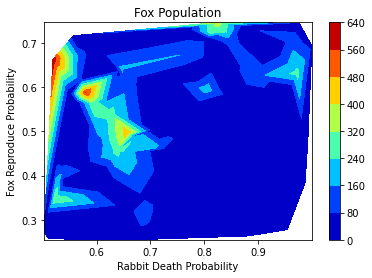

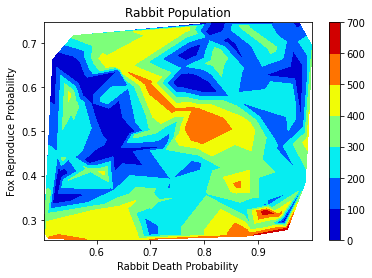

'sortedRDS, sortedFRs, sortedFPops, sortedRPops = zip(*sorted(zip(rDs, fRs, fEndingPops, rEndingPops)))\n\nfPops2d = []\nrPops2d = [] \n\nfor i, rD in enumerate(rDs):\n  fRow = []\n  rRow = []\n  for j, fR in enumerate(fRs):\n    fRow.append(sortedFPops[j])\n    rRow.append(sortedRPops[j])\n\n  fPops2d.append(fRow)\n  rPops2d.append(rRow)\n\nplt.imshow(fPops2d)'

In [11]:
rDs = params[:,1]*0.5+0.5
fRs = params[:,3]*0.5+0.25

triang = matplotlib.tri.Triangulation(rDs, fRs) 
tcf = plt.tricontourf(triang, fEndingPops, cmap='jet')
  
plt.colorbar(tcf) 
plt.xlabel('Rabbit Death Probability')
plt.ylabel('Fox Reproduce Probability')
plt.title('Fox Population')
plt.show()

triang = matplotlib.tri.Triangulation(rDs, fRs) 
tcf = plt.tricontourf(triang, rEndingPops, cmap='jet')
  
plt.colorbar(tcf) 
plt.xlabel('Rabbit Death Probability')
plt.ylabel('Fox Reproduce Probability')
plt.title('Rabbit Population')
plt.show()

"""xi = np.linspace(0, max(rDs), len(rDs))
yi = np.linspace(0, max(fRs), len(fRs))

for z in [fEndingPops, rEndingPops]:
  triang = matplotlib.tri.Triangulation(rDs, fRs)
  interpolator = matplotlib.tri.LinearTriInterpolator(triang, fEndingPops)
  Xi, Yi = np.meshgrid(xi, yi)
  zi = interpolator(Xi, Yi)
  plt.tricontourf(xi, yi, zi)"""


"""sortedRDS, sortedFRs, sortedFPops, sortedRPops = zip(*sorted(zip(rDs, fRs, fEndingPops, rEndingPops)))

fPops2d = []
rPops2d = [] 

for i, rD in enumerate(rDs):
  fRow = []
  rRow = []
  for j, fR in enumerate(fRs):
    fRow.append(sortedFPops[j])
    rRow.append(sortedRPops[j])

  fPops2d.append(fRow)
  rPops2d.append(rRow)

plt.imshow(fPops2d)"""

In [ ]:
plt.